# Imports

In [23]:
import cudf as pd
import cupy
import dask
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import random
import shap
import seaborn as sns
import tensorflow as tf

from cuml import RandomForestRegressor as CudaRandomForest
from cuml.metrics import mean_absolute_error
from shap.plots import colors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

SEED = 100

def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)
    np.random.seed(rnd_seed)
    cupy.random.seed(rnd_seed)
    tf.random.set_seed(rnd_seed)

reset_seed()


# Load Datasets

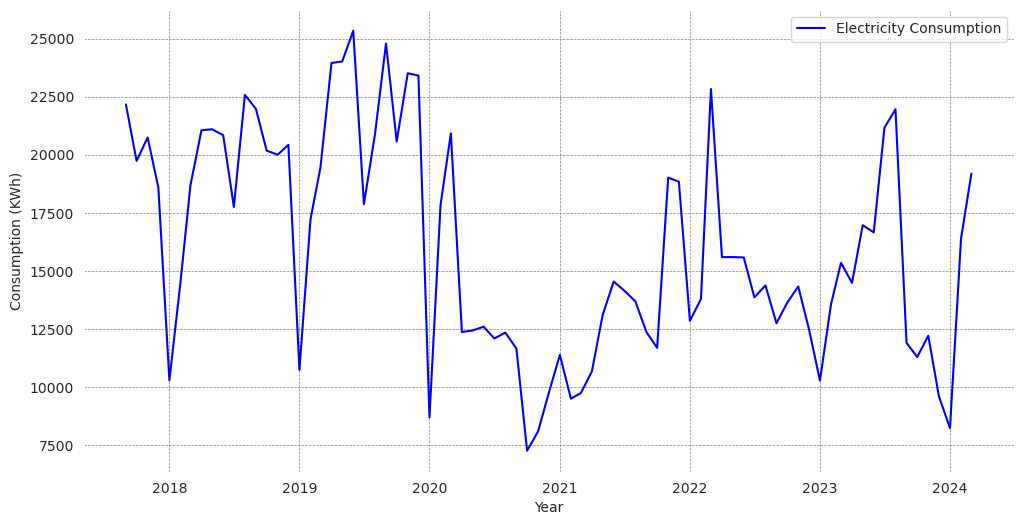

In [24]:
df_electricity = pd.read_csv('dataset/electricity.csv', sep=";", decimal=",", header=0)
df_climatic = pd.read_csv('dataset/climatic.csv', sep=";", decimal=",", header=0)

df_electricity["date"] = pd.to_datetime(df_electricity["date"], format="%d/%m/%Y")
df_climatic["date"] = pd.to_datetime(df_climatic["date"], format="%d/%m/%Y")

df_electricity.set_index("date", inplace=True)
df_climatic.set_index("date", inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_electricity["consumption"], label="Electricity Consumption", color="blue")
plt.xlabel('Year')
plt.ylabel('Consumption (KWh)')

ax = plt.gca()
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
plt.legend(facecolor='white')
plt.show()
    

# Pré-Processamento

## Dados climáticos faltantes

In [25]:
for index, row in df_climatic[df_climatic.isnull()].to_pandas().iterrows():
    df_mes = df_climatic[df_climatic["month"] == df_climatic.at[index, "month"]]
    for col in row.index:
        if pandas.isnull(df_climatic.at[index, col]):
            df_mes.at[index, col] = df_mes[col].sum() / df_mes[col][df_mes[col].isnull() == False].count()
            df_climatic.at[index, col] = df_mes.at[index, col]


## Obtenção dos LAGS

In [26]:
for lag_col in ["consumption"]:
    for i in range(1, 12 + 1):
        lag_eletricity = df_electricity[lag_col].shift(i)
        df_electricity[f'LAG_' + '{:02d}'.format(i)] = lag_eletricity


## União dos dados climáticos aos dados de consumption

In [27]:
df_electricity = pd.merge(left=df_electricity, right=df_climatic, on=["date", "month", "year"], how="left").sort_index()
df_electricity = df_electricity.drop("date_measure", axis=1)


## Criação das variáveis Dummy (mês e ano)

In [28]:
df_meses = pd.get_dummies(df_electricity["month"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"1": "month_JAN", "2": "month_FEV", "3": "month_MAR", "4": "month_ABR", "5": "month_MAI", "6": "month_JUN",
             "7": "month_JUL", "8": "month_AGO", "9": "month_SET", "10": "month_OUT", "11": "month_NOV",
             "12": "month_DEZ"}
)
df_anos = pd.get_dummies(df_electricity["year"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"2017": "year_2017", "2018": "year_2018", "2019": "year_2019", "2020": "year_2020", "2021": "year_2021",
             "2022": "year_2022", "2023": "year_2023", "2024": "year_2024"}
)
df_electricity = pd.concat([df_electricity, df_meses, df_anos], axis=1)
df_electricity = df_electricity.drop(["month", "year"], axis=1)
df_electricity = df_electricity.astype("float32").dropna()

df_show = df_electricity.to_pandas()
df_show

,consumption,covid,LAG_01,LAG_02,LAG_03,LAG_04,LAG_05,LAG_06,LAG_07,LAG_08,...,month_NOV,month_DEZ,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
date,,,,,,,,,,,,,,,,,,,,,
2018-09-01,21969.0,0.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,14487.0,10280.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-01,20174.0,0.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,14487.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-01,19998.0,0.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-01,20426.0,0.0,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01,10732.0,0.0,20426.0,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,12207.0,0.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,14480.0,15342.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2023-12-01,9588.0,0.0,12207.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,14480.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-01-01,8226.0,0.0,9588.0,12207.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Análise de Correlações


### Correlação com os LAGS

<Axes: >

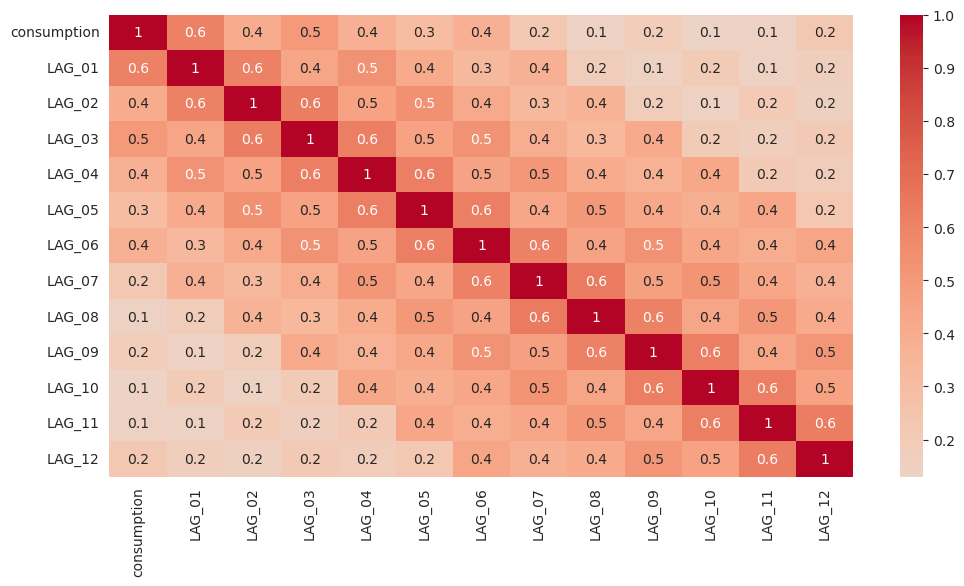

In [29]:
columns = df_electricity.to_pandas().filter(like="LAG_").columns.tolist()
columns.insert(0, "consumption")

corr_matrix = df_electricity[columns].dropna().to_pandas().corr(
    numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g',
            ax=ax)

### Correlação com as outras variáveis

<Axes: >

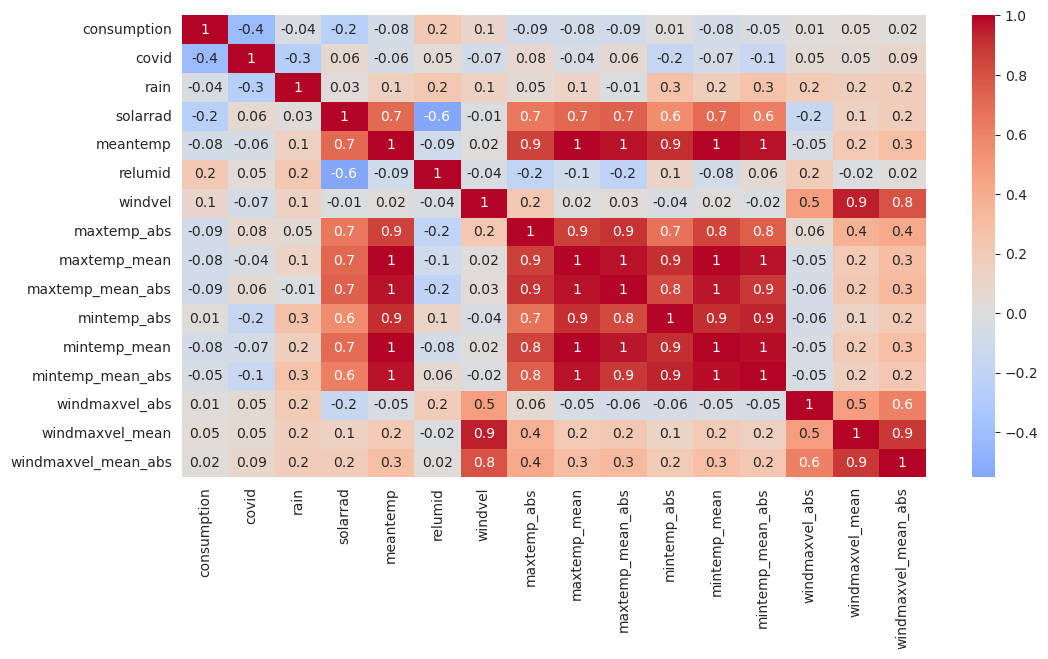

In [36]:
corr_matrix = df_electricity.drop(df_electricity.to_pandas().filter(like="LAG_").columns,
                                  axis=1).drop(df_electricity.to_pandas().filter(like="month_").columns,
                                               axis=1).drop(df_electricity.to_pandas().filter(like="year_").columns,
                                                            axis=1).dropna().to_pandas().corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g',
            ax=ax)

# Análise dos SHAP values


### Random Forest

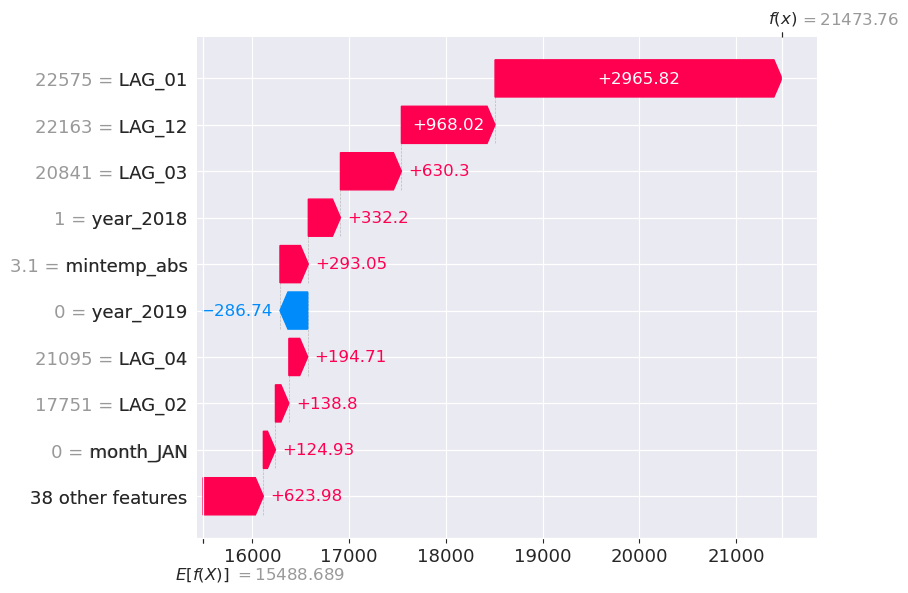

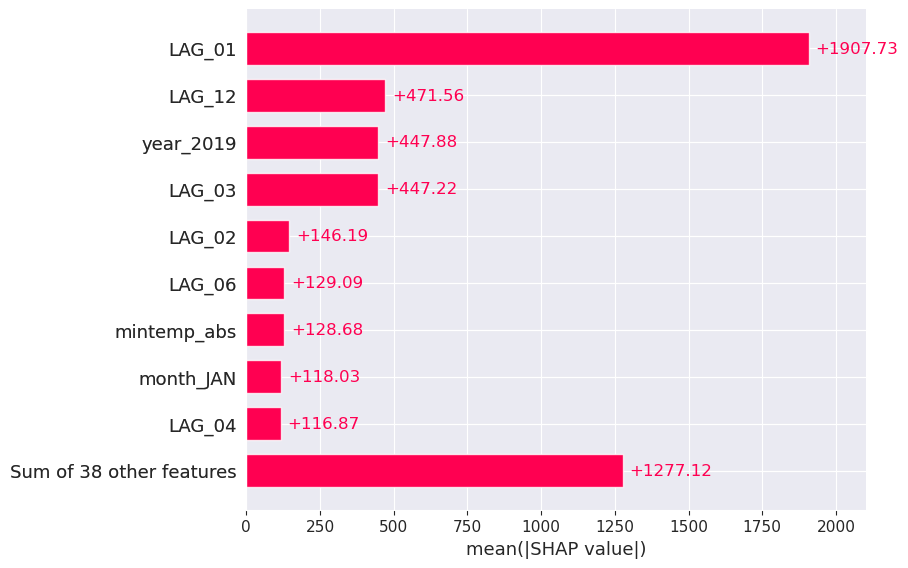

,feature,rf importance
39,year_2017,0.000000
32,month_JUN,0.796520
46,year_2024,1.477337
38,month_DEZ,1.497632
33,month_JUL,1.882618
35,month_SET,2.034362
30,month_ABR,2.047440
34,month_AGO,2.374549
43,year_2021,2.401500
37,month_NOV,2.755783


In [31]:
df_electricity_copy = df_electricity.copy().to_pandas()

x_electricity = df_electricity_copy.drop("consumption", axis=1)
y_electricity = df_electricity_copy["consumption"]
model_rf_electr = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=SEED)
shap.initjs()

model_rf_electr.fit(x_electricity, y_electricity)

explainer_rf_electr = shap.Explainer(model_rf_electr)
shap_rf_electr = explainer_rf_electr(x_electricity)

shap.plots.waterfall(shap_rf_electr[0], max_display=10)
shap.plots.force(shap_rf_electr[0])
shap.plots.bar(shap_rf_electr)

importance_rf_electr = pandas.DataFrame(list(zip(x_electricity.columns, np.abs(shap_rf_electr.values).mean(0))),
                                        columns=["feature", "rf importance"])
importance_rf_electr = importance_rf_electr.sort_values(by=["rf importance"])
importance_rf_electr

### XGBoost

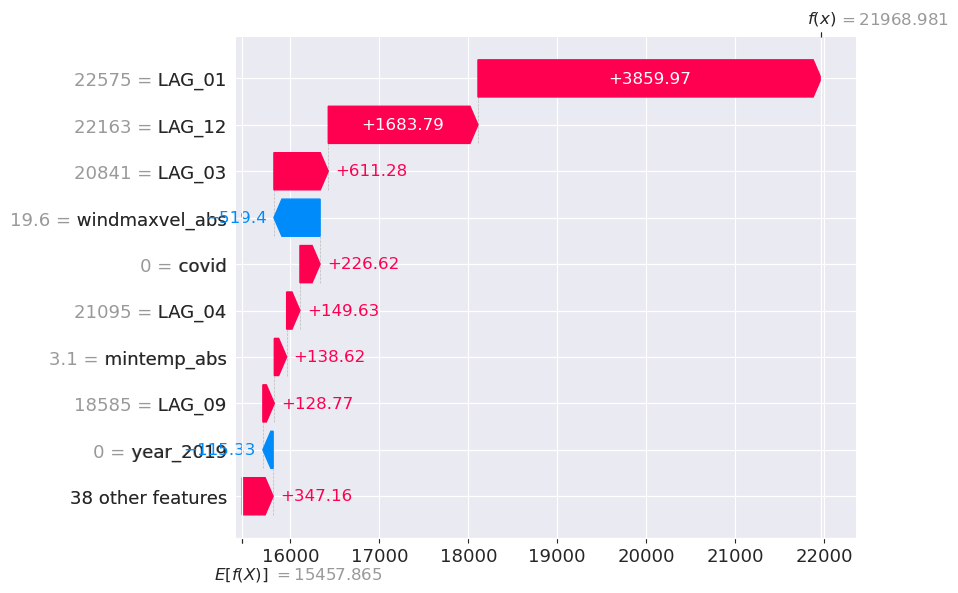

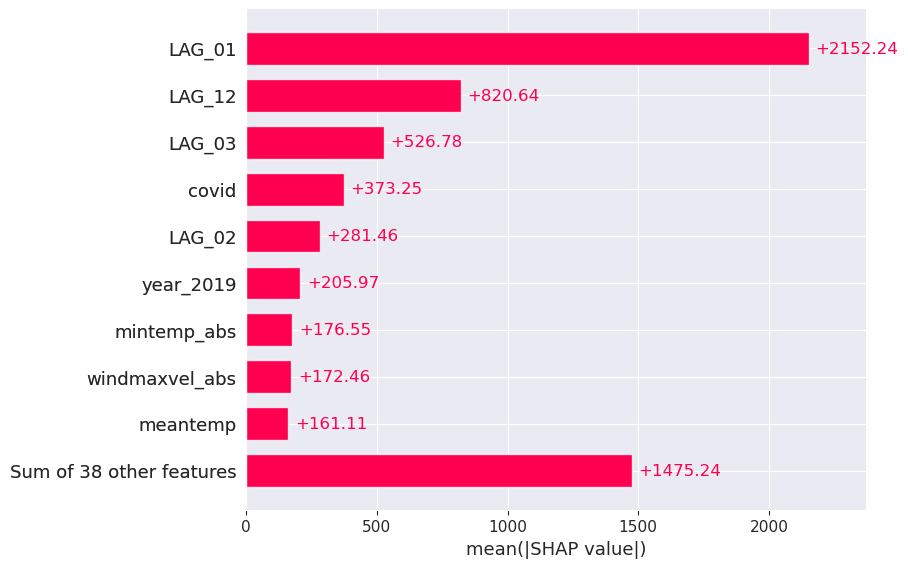

,feature,xgb importance
34,month_AGO,0.000000
45,year_2023,0.000000
43,year_2021,0.000000
40,year_2018,0.000000
39,year_2017,0.000000
38,month_DEZ,0.000000
28,month_FEV,0.000000
35,month_SET,0.000000
22,mintemp_mean,0.000000
30,month_ABR,0.000000


In [32]:
df_electricity_copy = df_electricity.copy().to_pandas()

x_electricity = df_electricity_copy.drop("consumption", axis=1)
y_electricity = df_electricity_copy["consumption"]

model_xgb_electr = XGBRegressor(booster="gbtree", objective='reg:squarederror', random_state=SEED)
shap.initjs()

model_xgb_electr.fit(x_electricity, y_electricity)

explainer_xgb_electr = shap.Explainer(model_xgb_electr)
shap_xgb_electr = explainer_xgb_electr(x_electricity)

shap.plots.waterfall(shap_xgb_electr[0], max_display=10)
shap.plots.force(shap_xgb_electr[0])
shap.plots.bar(shap_xgb_electr)

importance_xgb_electr = pandas.DataFrame(list(zip(x_electricity.columns, np.abs(shap_xgb_electr.values).mean(0))),
                                         columns=["feature", "xgb importance"])
importance_xgb_electr = importance_xgb_electr.sort_values(by=["xgb importance"])
importance_xgb_electr

### Média entre RF e XGB

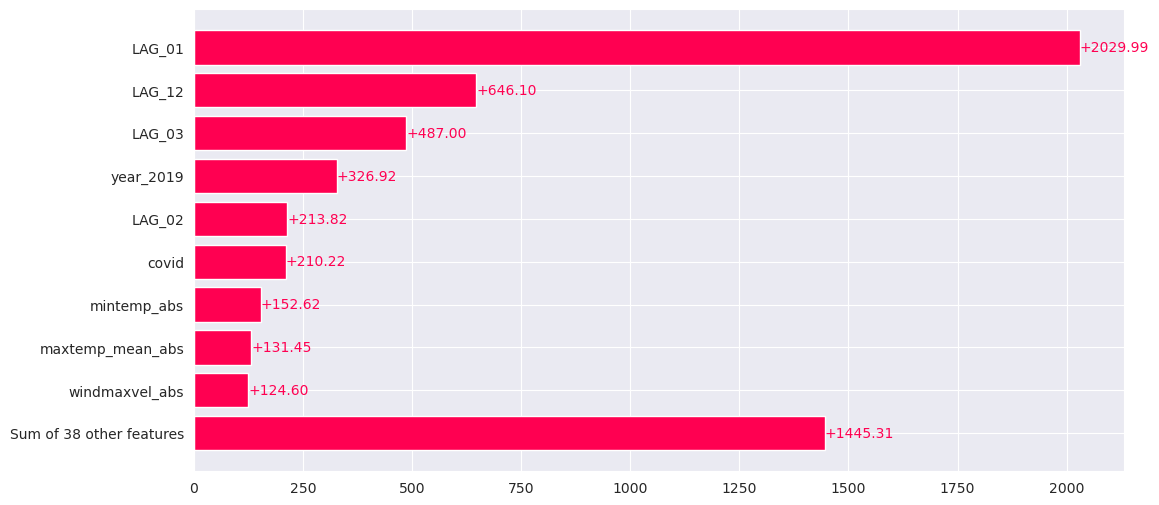

,feature,Mean RF/XGB importance
39,year_2017,0.000000
32,month_JUN,0.398260
46,year_2024,0.738752
38,month_DEZ,0.748816
33,month_JUL,0.957908
35,month_SET,1.017181
30,month_ABR,1.023720
34,month_AGO,1.187275
43,year_2021,1.200750
45,year_2023,2.164791


In [33]:
importance_electr = pandas.DataFrame(list(zip(x_electricity.columns, (
        np.abs(shap_rf_electr.values).mean(0) + np.abs(shap_xgb_electr.values).mean(0)) / 2)),
                                     columns=["feature", "Mean RF/XGB importance"])
importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"], ascending=False)

plt.figure(figsize=(12, 6))

bar_features_electr = list(importance_electr[0:9]["feature"])
bar_features_electr.append(f"Sum of {len(importance_electr[9:])} other features")
bar_importances_electr = list(importance_electr[0:9]["Mean RF/XGB importance"])
bar_importances_electr.append(importance_electr[9:]["Mean RF/XGB importance"].sum())

bar_features_electr = bar_features_electr[::-1]
bar_importances_electr = bar_importances_electr[::-1]

bars = plt.barh(bar_features_electr, bar_importances_electr, color=colors.red_rgb)

for bar, importance in zip(bars, bar_importances_electr):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'+{importance:.2f}',
             va='center', ha='left', color=colors.red_rgb)

plt.show()
importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"])
importance_electr


# Seleção de Features


In [39]:
importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"])


def ft_removal_rf(n_ft_removed, dataset):
    df_selected = dataset[n_ft_removed:]["feature"]
    x = df_electricity[df_selected]
    y = df_electricity["consumption"]

    rf_fs_electr = CudaRandomForest(n_bins=x.shape[0], random_state=SEED)

    cvs_rf = []
    for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
        x_train, x_test = x.iloc[i_train].to_cupy(), x.iloc[i_test].to_cupy()
        y_train, y_test = y.iloc[i_train].to_cupy(), y.iloc[i_test].to_cupy()

        rf_fs_electr.fit(x_train, y_train)
        cvs_rf.append(int(mean_absolute_error(y_test, rf_fs_electr.predict(x_test))))
    return int(np.array(cvs_rf).mean())


def ft_removal_xgb(n_ft_removed, dataset):
    df_selected = dataset[n_ft_removed:]["feature"]

    x = df_electricity[df_selected]
    y = df_electricity["consumption"]

    xgb_fs_electr = XGBRegressor(device="cuda", random_state=SEED)

    cvs_xgb = []
    for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x, y):
        x_train, x_test = x.iloc[i_train].to_cupy(), x.iloc[i_test].to_cupy()
        y_train, y_test = y.iloc[i_train].to_cupy(), y.iloc[i_test].to_cupy()

        xgb_fs_electr.fit(x_train, y_train)
        cvs_xgb.append(int(mean_absolute_error(y_test, xgb_fs_electr.predict(x_test))))

    return int(np.array(cvs_xgb).mean())


importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"])

ft_rm_rf_electr = dask.compute(
    [dask.delayed(ft_removal_rf)(i, importance_electr) for i in range(importance_electr["feature"].shape[0])])[0]
ft_rm_xgb_electr = dask.compute(
    [dask.delayed(ft_removal_xgb)(i, importance_electr) for i in range(importance_electr["feature"].shape[0])])[0]


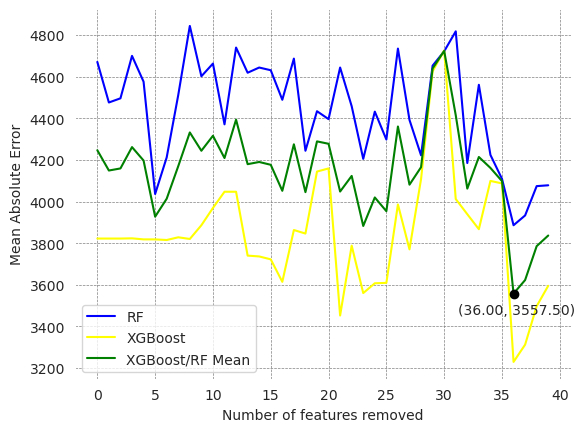

,consumption,covid,LAG_01,LAG_02,LAG_03,LAG_06,LAG_12,maxtemp_mean_abs,mintemp_abs,windmaxvel_abs,month_MAR,year_2019
date,,,,,,,,,,,,
2018-09-01,21969.0,0.0,22575.0,17751.0,20841.0,18671.0,22163.0,22.250000,3.100000,19.600000,0.0,0.0
2018-10-01,20174.0,0.0,21969.0,22575.0,17751.0,21052.0,19732.0,22.370001,7.500000,18.000000,0.0,0.0
2018-11-01,19998.0,0.0,20174.0,21969.0,22575.0,21095.0,20742.0,26.120001,11.200000,16.600000,0.0,0.0
2018-12-01,20426.0,0.0,19998.0,20174.0,21969.0,20841.0,18585.0,27.760000,6.900000,19.100000,0.0,0.0
2019-01-01,10732.0,0.0,20426.0,19998.0,20174.0,17751.0,10280.0,28.320000,16.200001,15.800000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,12207.0,0.0,11286.0,11897.0,21955.0,16964.0,14326.0,24.910000,4.300000,16.200001,0.0,0.0
2023-12-01,9588.0,0.0,12207.0,11286.0,11897.0,16655.0,12500.0,27.150000,11.800000,15.700000,0.0,0.0
2024-01-01,8226.0,0.0,9588.0,12207.0,11286.0,21165.0,10272.0,26.299999,10.600000,16.700001,0.0,0.0


In [40]:
ft_rm_mean_electr = (np.array(ft_rm_rf_electr) + np.array(ft_rm_xgb_electr)) / 2
min_index = np.argmin(ft_rm_mean_electr[:40])

plt.plot([x for x in ft_rm_rf_electr[:40]], label="RF", color="blue")
plt.plot([x for x in ft_rm_xgb_electr[:40]], label="XGBoost", color="yellow")
plt.plot([x for x in ft_rm_mean_electr[:40]], label="XGBoost/RF Mean", color="green")
plt.scatter(min_index, ft_rm_mean_electr[min_index], color='black', zorder=2)
plt.annotate(f"({min_index:.2f}, {ft_rm_mean_electr[min_index]:.2f})", xy=(min_index, ft_rm_mean_electr[min_index]),
             xytext=(-40, -15), textcoords='offset points', fontsize=10)

plt.xlabel('Number of features removed')
plt.ylabel('Mean Absolute Error')
ax = plt.gca()
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
plt.legend(facecolor='white')
plt.show()
importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"])
df_electricity_selected = df_electricity.drop(importance_electr[:min_index]["feature"], axis=1)
df_electricity_selected.to_pandas().to_csv(f"dataset/elect_merged_selected.csv", sep=";", decimal=",")
df_electricity_selected